In [1]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch import nn

from shiba import Trainer
from shiba.callbacks import TensorBoard, Metric, Save
from shiba.metrics import categorical_accuracy
from shiba.vis import vis_classify
import matplotlib.pyplot as plt

%matplotlib inline

## Load Data

In [2]:
train_dataset = CIFAR10('../data/cifar', train=True, transform=ToTensor())
val_dataset = CIFAR10('../data/cifar', train=False, transform=ToTensor())

## SimpleNet

In [3]:
class SimpleNet(nn.Module):
    """A simple convnet with 2 conv layers and a fully connected layer"""
    def __init__(self, in_channels, out_channels):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 8, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.fc = nn.Linear(16 * 8 * 8, out_channels)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        return self.fc(x.view(x.size(0), -1))


In [4]:
model = SimpleNet(in_channels=3, out_channels=10)
criterion = nn.CrossEntropyLoss()
trainer = Trainer(model, criterion)
!rm -rf ../runs/shiba-test-cifar # clear tb logs

## LR finder

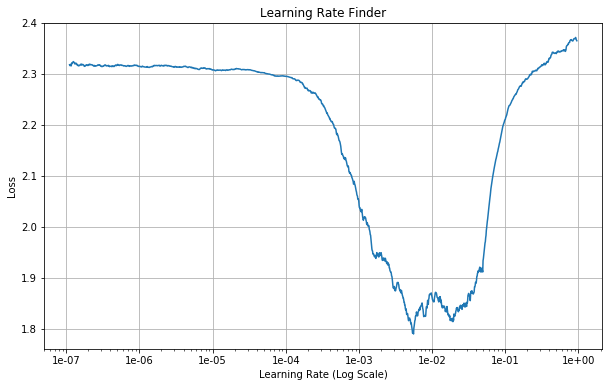

In [5]:
trainer.find_lr(train_dataset)

## Callbacks

In [6]:
callbacks = [TensorBoard(log_dir='../runs/shiba-test-cifar', vis_function=vis_classify),
             Metric(name='accuracy', score_func=categorical_accuracy),
             Save('../weights/cifar', monitor='val_loss')]

## Fit One Cycle 

In [7]:
trainer.fit_one_cycle(train_dataset, val_dataset, epochs=3, max_lr=5e-3, callbacks=callbacks)

In [8]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


## LR finder again

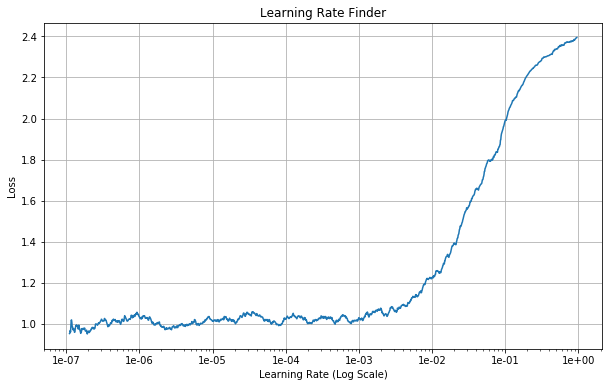

In [9]:
trainer.find_lr(train_dataset)

## Fit Constant LR

In [10]:
trainer.fit(train_dataset, val_dataset, epochs=5, lr=3e-4, callbacks=callbacks)